In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from scipy import stats
import datetime as dt
import scipy.interpolate as interpolate
from mySSA import mySSA

In [12]:
volc = np.genfromtxt('nature14565-s6_sigl2015.csv', delimiter=",", dtype=float)
data_ipsl_ = np.genfromtxt('tas_Amon_IPSL-CM5A-LR_past1000_r1i1p1_0850_1850_nino3_tseries.csv', delimiter=",", dtype=float)[0:12000]-273.15
data_giss_ = np.genfromtxt('tos_Omon_GISS-E2-R_past1000_r1i1p128_0850_1850_nino3_tseries.csv', delimiter=",", dtype=float)[0:12000]-273.15
data_mpi_ = np.genfromtxt('tos_Amon_MPI-ESM-P_past1000_r1i1p1_0850_1850_nino3_tseries.csv', delimiter=",", dtype=float)[0:12000]-273.15
yy = np.arange(850,1850,1/12)

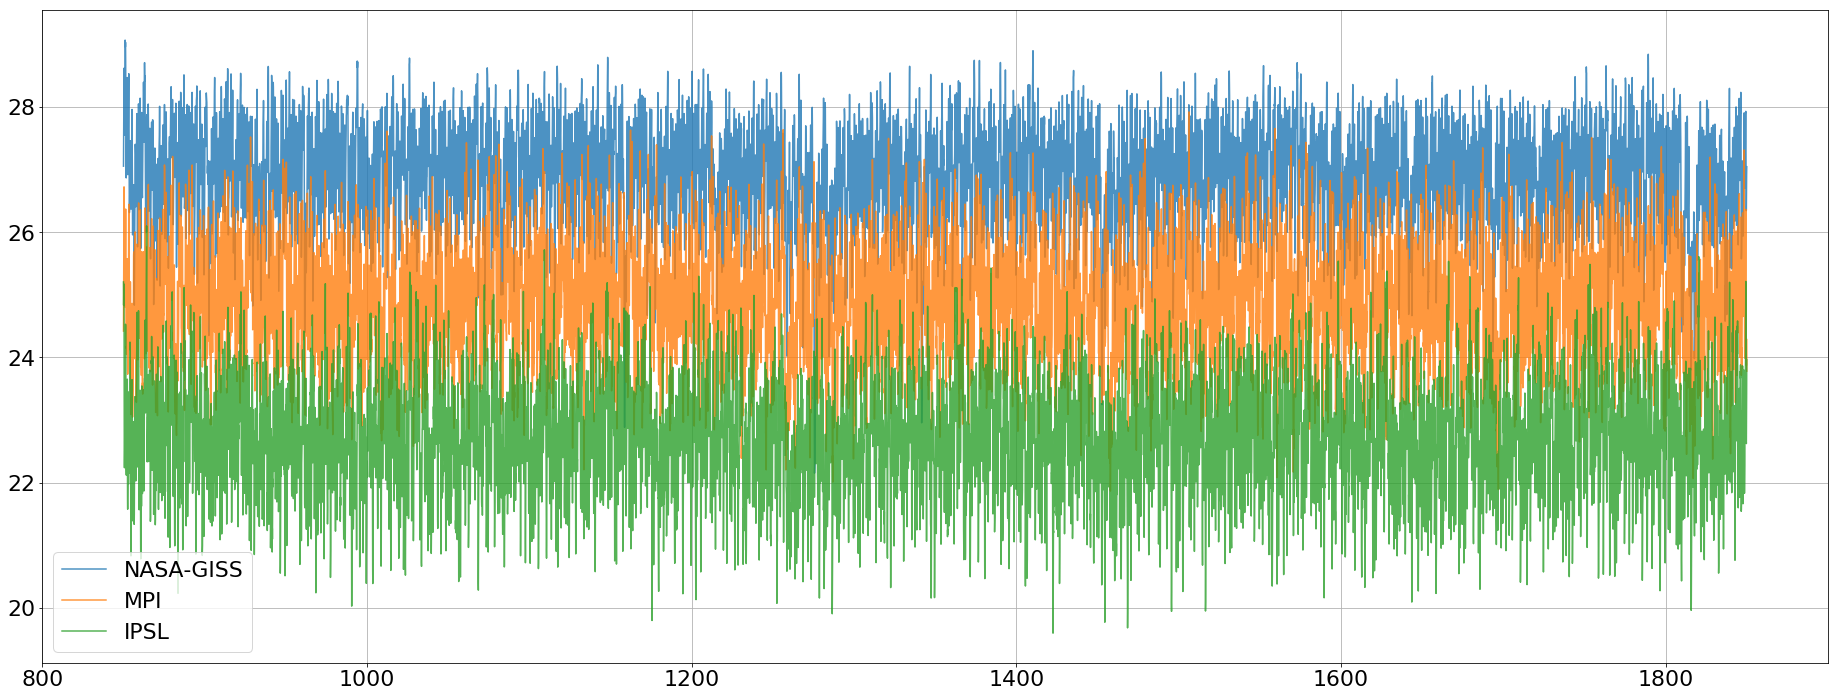

In [13]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(32,12))
plt.plot(yy, data_giss_, label='NASA-GISS', alpha=0.8)
plt.plot(yy, data_mpi_, label='MPI', alpha=0.8)
plt.plot(yy, data_ipsl_, label='IPSL', alpha=0.8)
plt.legend()
plt.grid()

In [15]:
# Singular Spectral Analysis as in Sinha et al 2015
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

def ssa(F):
    N = F.shape[0]
    L = 160# The window length.
    K = N - L + 1 # The number of columns in the trajectory matrix.
    # Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
    X = np.column_stack([F[i:i+L] for i in range(0,K)])
    # Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 
    d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
    U, Sigma, V = np.linalg.svd(X)
    V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
    n = min(12,d) # In case of noiseless time series with d < 12.
    # Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
    F_i = np.zeros((n,N))
    for i in range(n):
        F_i[i,:] = X_to_TS(X_elem[i])
    return F_i

In [16]:
# Long Term monthly mean removal by Singular Spectral Analysis 
# This can be a very good start as an input to the 
# phase coherence analysis
data_ipsl = data_ipsl_
data_giss = data_giss_
data_mpi = data_mpi_
for i in range(12):
    data_ssa = ssa(data_ipsl_[i::12])
    data_ipsl[i::12] =  data_ipsl_[i::12] - data_ssa[0]
    data_ssa = ssa(data_mpi_[i::12])
    data_mpi[i::12] =  data_mpi_[i::12] - data_ssa[0]
    data_ssa = ssa(data_giss_[i::12])
    data_giss[i::12] =  data_giss_[i::12] - data_ssa[0]

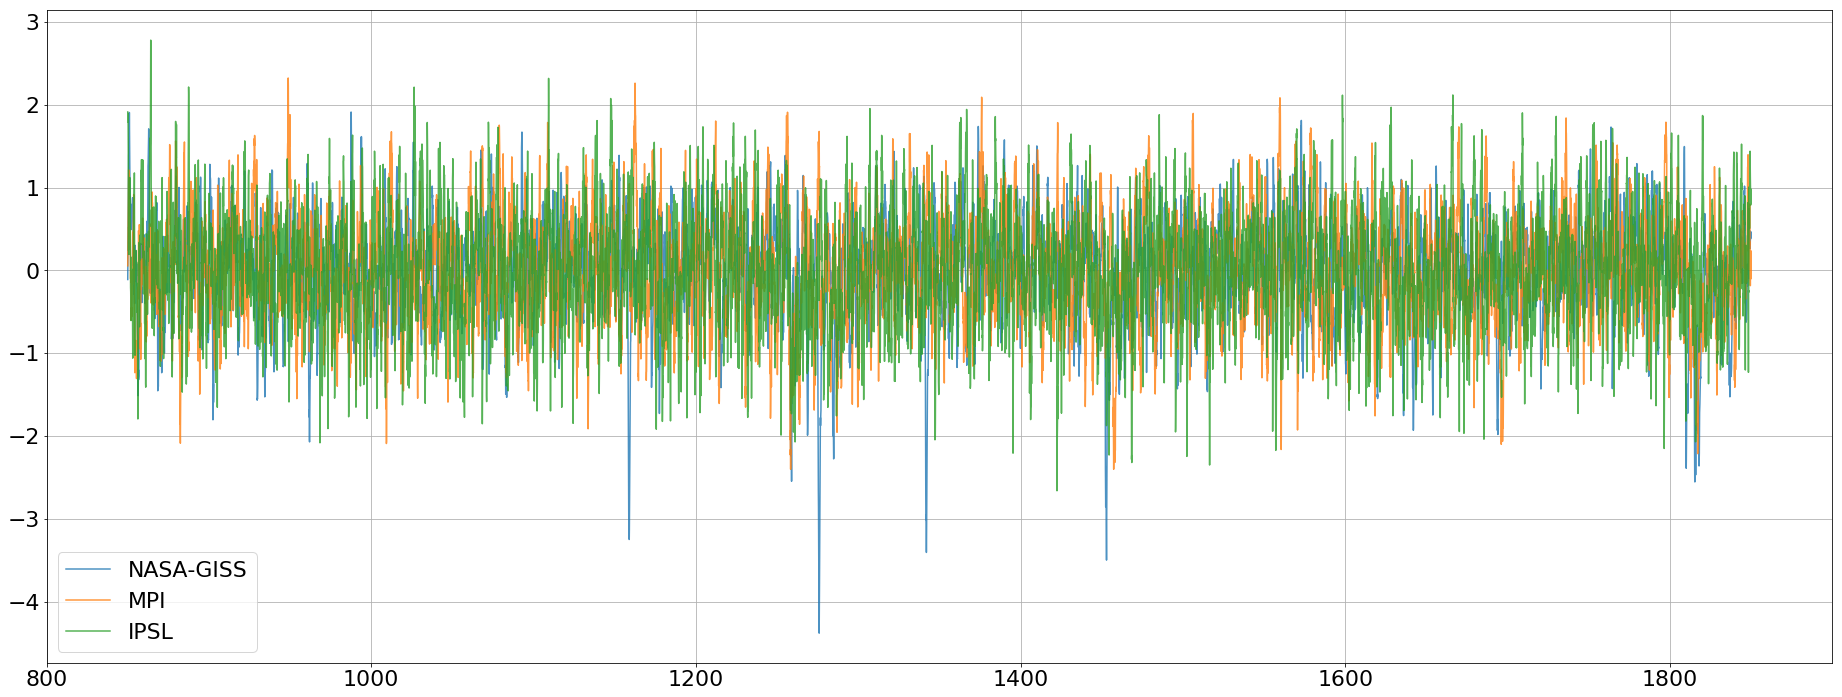

In [17]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(32,12))
plt.plot(yy, data_giss, label='NASA-GISS', alpha=0.8)
plt.plot(yy, data_mpi, label='MPI', alpha=0.8)
plt.plot(yy, data_ipsl, label='IPSL', alpha=0.8)
plt.legend()
plt.grid()

Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period. https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni

In [23]:
# Subtract monthly climatologies to calculate anomaly

data_ipsl_anom = data_ipsl
data_giss_anom = data_giss
data_mpi_anom = data_mpi

for i in range(12):
    data_ipsl_anom[i::12] =  data_ipsl[i::12] - np.mean(data_ipsl[i::12])
    data_mpi_anom[i::12]  =  data_mpi[i::12] - np.mean(data_mpi[i::12])
    data_giss_anom[i::12] =  data_giss[i::12] - np.mean(data_giss[i::12])

# Smooth the monthly anomaly series with 5 month running mean
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

data_ipsl_anom_run = runningMeanFast(data_ipsl_anom,5)
data_giss_anom_run = runningMeanFast(data_giss_anom,5)
data_mpi_anom_run = runningMeanFast(data_mpi_anom,5)

# Normalize the smoothed data with climatological standard deviation

data_ipsl_anom_run_norm = data_ipsl_anom_run
data_giss_anom_run_norm = data_giss_anom_run
data_mpi_anom_run_norm = data_mpi_anom_run


for i in range(12):
    data_ipsl_anom_run_norm[i::12] =  data_ipsl_anom_run[i::12] / np.std(data_ipsl_anom_run[i::12])
    data_mpi_anom_run_norm[i::12]  =  data_mpi_anom_run[i::12] / np.std(data_mpi_anom_run[i::12])
    data_giss_anom_run_norm[i::12] =  data_giss_anom_run[i::12] / np.std(data_giss_anom_run[i::12])


In [24]:
# Calculating average Nino3 from July-December to classify whether an year is an El 
# Nino or La Nina (Trenberth, 1997)
yy_ann = np.arange(850,1850)
data_ipsl_ann = np.zeros((yy_ann.shape[0]))
data_giss_ann = np.zeros((yy_ann.shape[0]))
data_mpi_ann = np.zeros((yy_ann.shape[0]))
for i in range(yy_ann.shape[0]):
    #print(np.arange(i*12+6,(i+1)*12))
    data_ipsl_ann[i] = np.mean(data_ipsl_anom_run_norm[i*12+6:(i+1)*12])
    data_giss_ann[i] = np.mean(data_giss_anom_run_norm[i*12+6:(i+1)*12])
    data_mpi_ann[i] = np.mean(data_mpi_anom_run_norm[i*12+6:(i+1)*12])

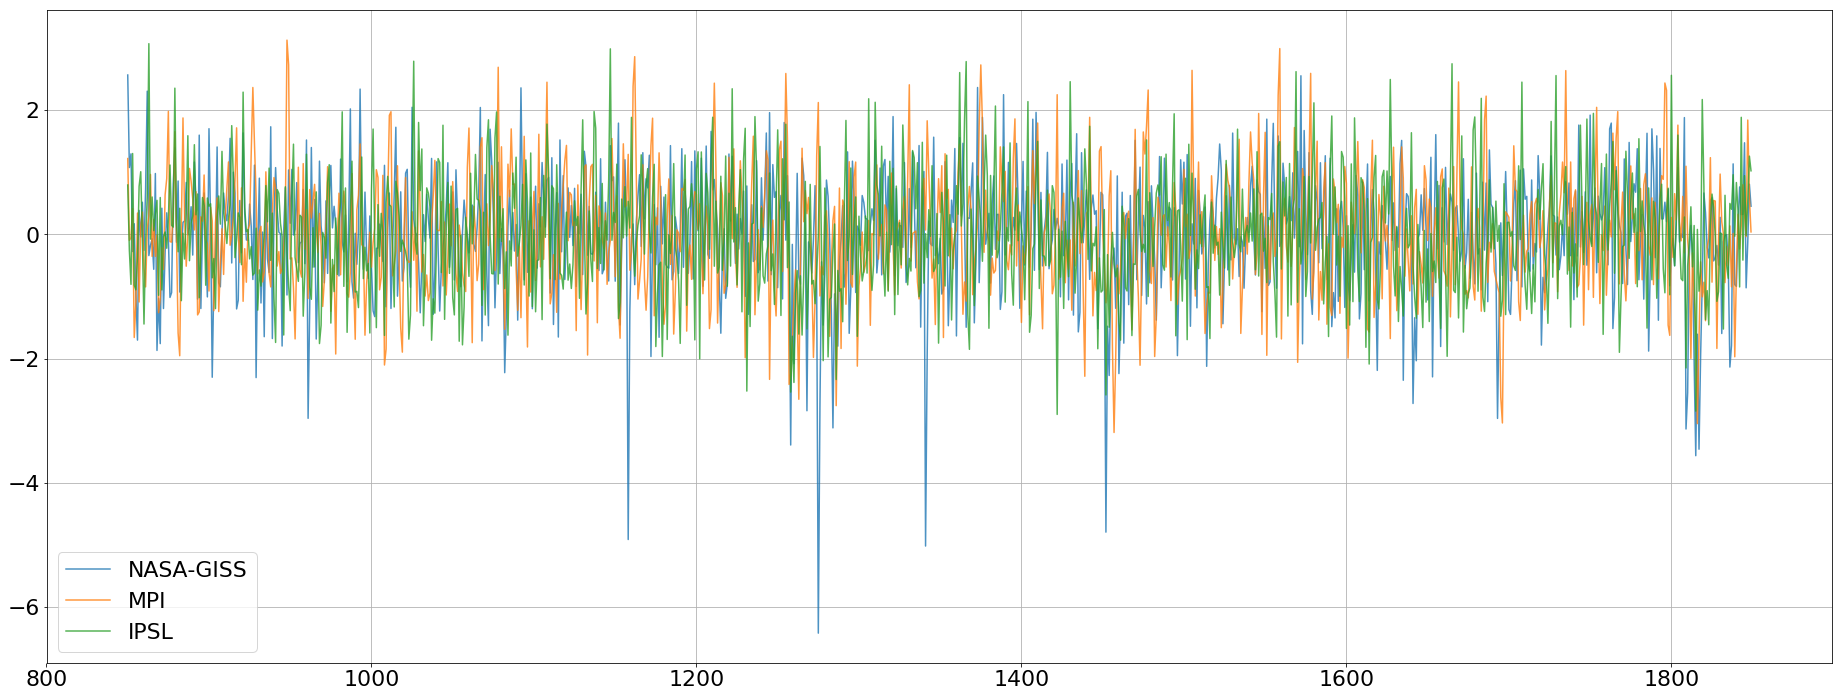

In [25]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(32,12))
plt.plot(yy_ann, data_giss_ann, label='NASA-GISS', alpha=0.8)
plt.plot(yy_ann, data_mpi_ann, label='MPI', alpha=0.8)
plt.plot(yy_ann, data_ipsl_ann, label='IPSL', alpha=0.8)
plt.legend()
plt.grid()

In [27]:
event_en_ipsl = np.zeros((yy_ann.shape[0]))
event_en_giss = np.zeros((yy_ann.shape[0]))
event_en_mpi = np.zeros((yy_ann.shape[0]))
event_yy_volc_all = np.zeros((yy_ann.shape[0]))
event_yy_volc_strong = np.zeros((yy_ann.shape[0]))
event_yy_volc_all_trop = np.zeros((yy_ann.shape[0]))
event_yy_volc_all_nh = np.zeros((yy_ann.shape[0]))
event_yy_volc_all_sh = np.zeros((yy_ann.shape[0]))
event_yy_volc_strong_trop = np.zeros((yy_ann.shape[0]))
event_yy_volc_strong_nh = np.zeros((yy_ann.shape[0]))
event_yy_volc_strong_sh = np.zeros((yy_ann.shape[0]))

In [28]:
event_en_ipsl[data_ipsl_ann>0.5] = 1.0
event_en_giss[data_giss_ann>0.5] = 1.0
event_en_mpi[data_mpi_ann>0.5] = 1.0

for i in range(yy_ann.shape[0]):
    #print(event_yy_kobb[i])
    idx = np.asarray(np.where(volc[:,0] == yy_ann[i]))
    #print(idx.size)
    if idx.size==0:
        continue
    event_yy_volc_all[i] = 1.0
    if np.abs(volc[idx[0,0],2])>=3.7:
        event_yy_volc_strong[i] = 1.0
    
    if volc[idx[0,0],1] == 1.0:
        event_yy_volc_all_trop[i] = 1.0
    if volc[idx[0,0],1] == 2.0:
        event_yy_volc_all_nh[i] = 1.0
    if volc[idx[0,0],1] == 3.0:
        event_yy_volc_all_sh[i] = 1.0
        
    if (volc[idx[0,0],1] == 1.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_trop[i] = 1.0
    if (volc[idx[0,0],1] == 2.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_nh[i] = 1.0
    if (volc[idx[0,0],1] == 3.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_sh[i] = 1.0

In [29]:
np.savetxt('en_ipsl.txt', event_en_ipsl, delimiter=",")
np.savetxt('en_giss.txt', event_en_giss, delimiter=",")
np.savetxt('en_mpi.txt', event_en_mpi, delimiter=",")
np.savetxt('all_volc_pmip.txt', event_yy_volc_all, delimiter=",")
np.savetxt('strong_volc_pmip.txt', event_yy_volc_strong, delimiter=",")
np.savetxt('all_tropical_pmip.txt', event_yy_volc_all_trop, delimiter=",")
np.savetxt('strong_tropical_pmip.txt', event_yy_volc_strong_trop, delimiter=",")
np.savetxt('all_nh_pmip.txt', event_yy_volc_all_nh, delimiter=",")
np.savetxt('strong_nh_pmip.txt', event_yy_volc_strong_nh, delimiter=",")
np.savetxt('all_sh_pmip.txt', event_yy_volc_all_sh, delimiter=",")
np.savetxt('strong_sh_pmip.txt', event_yy_volc_strong_sh, delimiter=",")

In [42]:
np.sum(event_yy_volc_all_sh)

23.0